In [4]:
# General dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import time
from datetime import datetime, date, timedelta

# For Twitter API extraction
import tweepy
#!pip install python-dotenv
from dotenv import load_dotenv

# Tweet pre-processor
import preprocessor as p

# NLTK
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:

# Generate list of dates (7 days window) based on today's date
list_of_dates = []
today = date.today()
for i in range(-7,1):
    target_date = (today + timedelta(days=i)).strftime("%Y-%m-%d")
    list_of_dates.append(target_date)

In [21]:
   # Enter your own credentials obtained
    # from your developer account
consumer_key = "XXXXXXXXXXXXXXXXXXSFXU"
consumer_secret = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXf94Q9ykLT7Nq"
access_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXDrP1sPd"
access_secret = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXJDhnmSo"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [22]:
list_of_dicts = []
search_term = 'covid19 covid vaccine'
num_tweets = 5000

In [23]:

def get_tweets(search_term = search_term, num_tweets = num_tweets):
    
    for end_date in list_of_dates:
        start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=1)).strftime("%Y-%m-%d") # Create 1-day windows for extraction
        tweet_count = len(list_of_dicts)

        for tweet in tweepy.Cursor(api.search,
                                   q=f'{search_term} since:{start_date} until:{end_date}',
                                   lang = 'en',
                                   count = num_tweets,
                                   tweet_mode = 'extended').items(num_tweets):
            if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
                if tweet.lang == "en":
                    tweet_dict = {}
                    tweet_dict['username'] = tweet.user.name
                    tweet_dict['location'] = tweet.user.location
                    tweet_dict['text'] = tweet.full_text
                    #tweet_dict['fav_count'] = tweet.favorite_count  
                    tweet_dict['hashtags'] = tweet.entities['hashtags']
                    tweet_dict['tweet_date'] = tweet.created_at
                    list_of_dicts.append(tweet_dict)
                    tweet_count +=1
                
    print(f'Completed extraction for {start_date} to {end_date}')

In [24]:
# Run tweet extraction function
get_tweets()

Completed extraction for 2021-05-29 to 2021-05-30


In [25]:
# Number of tweets pulled
len(list_of_dicts)

7322

In [26]:
# Transform list of dictionaries into a Pandas dataframe
tweets_df = pd.DataFrame(list_of_dicts)
tweets_df.sort_values(by='tweet_date').reset_index(drop = True)

,username,location,text,hashtags,tweet_date
0,The Jerusalem Post,Israel,A new study from @UniofOxford has found that m...,"[{'text': 'COVID19', 'indices': [147, 155]}, {...",2021-05-23 03:15:00
1,Ryan Kift,,LOL\n \nLottery tickets or cash: experts say A...,"[{'text': 'NoVaccinePassports', 'indices': [93...",2021-05-23 03:20:08
2,Kyle “Kyohazard” Burles,Calgary,After harassment from @mikeriegerdraws I did a...,"[{'text': 'AZ', 'indices': [87, 90]}, {'text':...",2021-05-23 03:22:16
3,PIOTR WRÓBLEWSKI,,New post (US CDC investigates reports of heart...,[],2021-05-23 03:23:23
4,covidtamere,,Facebook’s Covid vaccine Fact Checkers are fun...,"[{'text': 'plandemic', 'indices': [71, 81]}, {...",2021-05-23 03:29:11
...,...,...,...,...,...
7317,Habari Entertainment,Phoenix,Feds say employers can require workers to get ...,"[{'text': 'COVID19', 'indices': [85, 93]}]",2021-05-29 23:32:43
7318,Christina Thielst,"Santa Barbara, CA",CA café charges patrons $5 if they wear a mask...,"[{'text': 'cancer', 'indices': [106, 113]}, {'...",2021-05-29 23:48:40
7319,Mary 💙❤️,Canada,If you want to call the pharmacist in your are...,"[{'text': 'Pfizer', 'indices': [136, 143]}, {'...",2021-05-29 23:48:41
7320,Thai News Reports,Thailand,"Bangkok Post Infographic: In June, Thailand wi...","[{'text': 'COVID19', 'indices': [130, 138]}, {...",2021-05-29 23:53:07


In [27]:
# Setup function to extract hashtags text from the raw hashtag dictionaries
def extract_hashtags(hashtag_list):
    
    s = "" # Create empty string
    if not hashtag_list: # If list is empty, return empty string
        return s
    else:
        for dictionary in hashtag_list:
            s+= str(dictionary['text'].lower() + ',') # Create string (lowercase) for each hashtag text
        s = s[:-1] # Drop last character ','
        return s

In [28]:
# Extract hashtags
tweets_df['hashtags_extracted'] = tweets_df['hashtags'].apply(lambda x: extract_hashtags(x))
tweets_df.drop(columns = 'hashtags', inplace = True)

In [29]:
tweets_df.head()

,username,location,text,tweet_date,hashtags_extracted
0,Medical Zirigoza Group,CE,😷 Covid-19 vaccine boosters may be necessary. ...,2021-05-23 23:57:01,"medical,groupzirigoza"
1,IAmWhatICreate,United States,So... I heard you can go into @Walgreens And g...,2021-05-23 23:50:22,covid19
2,Supervisor Wendy Root Askew,"Marina, CA",Great reminder that all youth 12 &amp; up are ...,2021-05-23 23:45:58,
3,PK,,‘I don’t think big brother ought to tell me to...,2021-05-23 23:42:09,
4,CarianneH,"Montclair, NJ","In school, we are taught that science has no f...",2021-05-23 23:39:51,"covid,covid19,vaccine,vaccinate,followthescience"


In [30]:
# Keep only tweets that involve the vaccine
tweets_df_final = tweets_df[(tweets_df['text'].str.contains("vacc")) 
                            | (tweets_df['text'].str.contains("Vacc"))
                            | (tweets_df['hashtags_extracted'].str.contains("vacc"))
                            | (tweets_df['hashtags_extracted'].str.contains("Vacc"))]
len(tweets_df_final)

6952

In [32]:

# Create timestamp for datetime of extraction
extract_datetime = datetime.today().strftime('%Y%m%d_%H%M%S')

# Create csv filename
filename = 'covid_vaccine_tweets_extracted_' + extract_datetime + '.csv'

# Drop duplicates (if any)
tweets_df_final.drop_duplicates(inplace = True)

# Export dataframe as csv file with above filename
tweets_df_final.to_csv(filename, index = False)

C:\Users\mshan\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
tweets_df_final.head()

,username,location,text,tweet_date,hashtags_extracted
0,Medical Zirigoza Group,CE,😷 Covid-19 vaccine boosters may be necessary. ...,2021-05-23 23:57:01,"medical,groupzirigoza"
1,IAmWhatICreate,United States,So... I heard you can go into @Walgreens And g...,2021-05-23 23:50:22,covid19
2,Supervisor Wendy Root Askew,"Marina, CA",Great reminder that all youth 12 &amp; up are ...,2021-05-23 23:45:58,
3,PK,,‘I don’t think big brother ought to tell me to...,2021-05-23 23:42:09,
4,CarianneH,"Montclair, NJ","In school, we are taught that science has no f...",2021-05-23 23:39:51,"covid,covid19,vaccine,vaccinate,followthescience"


PART 2: Text pre-processing

In [1]:
#pip install tweet-preprocessor

In [86]:
tweets_df_final = pd.read_csv("covid_vaccine_tweets_extracted_20210530_234644.csv")
tweets_df = tweets_df_final.copy()

In [87]:
# Clean tweet text with tweet-preprocessor
tweets_df['text_cleaned'] = tweets_df['text'].apply(lambda x: p.clean(x))

In [88]:
# Remove duplicate tweets
tweets_df.drop_duplicates(subset='text_cleaned', keep="first", inplace = True)

len(tweets_df)

5927

In [89]:
# Remove unnecessary characters
# Note: Need to remove % as Stanford CoreNLP annotation encounters error if text contains some of these characters
punct =['%','/',':','\\','&amp;','&',';']

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

tweets_df['text_cleaned'] = tweets_df['text_cleaned'].apply(lambda x: remove_punctuations(x))

In [96]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

add_words = ["coronavirus", "covid", "covid19","vaccination","vaccine","COVID-19"]
stop.extend(add_words)

tweets_df['text_cleaned'] = tweets_df['text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [97]:
# Drop tweets which have empty text field
tweets_df['text_cleaned'].replace('', np.nan, inplace=True)
tweets_df['text_cleaned'].replace(' ', np.nan, inplace=True)
tweets_df.dropna(subset=['text_cleaned'], inplace=True)
len(tweets_df)

5927

In [98]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.sample(5)

,username,location,text,tweet_date,hashtags_extracted,text_cleaned
781,Children's Hospital of Richmond at VCU,Central Virginia,The #COVID19 vaccine will play a major role in...,2021-05-24 20:30:09,"covid19,covidvaccine,pediatrics,childrenshospi...",The play major role ending pandemic. It's safe...
5790,Free the west,NaN,Covid19 proven to have come from Wuhan lab bey...,2021-05-29 06:57:48,"wuhanlab,itwaschinastupid,bioweapon",Covid19 proven come Wuhan lab beyond scientifi...
5116,Jagran English,"New Delhi, India",'India to vaccinate all by December 2021': @Pr...,2021-05-28 11:30:00,covid19,'India vaccinate December ' hits back policy
275,UK COVID-19 Vaccine Statistics,NaN,UK #covid19 #vaccine statistics for Saturday 2...,2021-05-23 16:00:37,"covid19,vaccine",UK statistics Saturday nd May first doses give...
5633,✨About Royals✨ (@aboutthecambridges),"England, Vereinigtes Königreic",The Duchess of Cambridge received her first do...,2021-05-29 12:21:53,"covid19,vaccine,london,katemiddleton,duchessof...",The Duchess Cambridge received first dose yest...


PART 3- Sentiment Analysis

In [99]:

# Define function to get value counts
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(tweets_df[col_name].value_counts())
    percentage = pd.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

PART 3A- VADER Sentiment

Natural Learning Toolkit (NLTK) is a Python package that offers programs supporting natural language processing (NLP). In addition to its text corpus, it also comes with pre-trained models.  In particular, we will be using the Valence Aware Dictionary and sEntiment Reasoner (VADER) model, which is a lexicon and rule-based sentiment analysis tool specifically aimed at sentiment analysis of social media text. It uses a bag of words approach with simple heuristics (such as increasing sentiment intensity in presence of certain words like "very" or "really").

After installing NLTK with the command pip install nltk, we can run sentiment analysis using VADER with these lines of code:

In [100]:
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
tweets_df['nltk_scores'] = tweets_df['text_cleaned'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
tweets_df['nltk_cmp_score'] = tweets_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

In [101]:
neutral_thresh = 0.05

In [102]:
# Categorize scores into the sentiments of positive, neutral or negative
tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

# Neutral score = 0
# tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c > 0 else ('Negative' if c < 0 else 'Neutral'))

In [103]:
tweets_df['nltk_cmp_score'].describe()

count    5927.000000
mean        0.139433
std         0.415146
min        -0.959100
25%         0.000000
50%         0.000000
75%         0.458800
max         0.975000
Name: nltk_cmp_score, dtype: float64

In [104]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,1214,20.48,NLTK Vader
1,Neutral,2015,34.00,NLTK Vader
2,Positive,2698,45.52,NLTK Vader


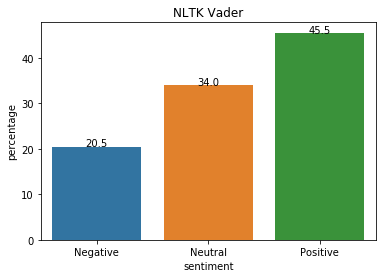

In [105]:
ax = sns.barplot(x="sentiment", y="percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

In [106]:
tweets_df.head()

,username,location,text,tweet_date,hashtags_extracted,text_cleaned,nltk_scores,nltk_cmp_score,nltk_sentiment
0,Medical Zirigoza Group,CE,😷 Covid-19 vaccine boosters may be necessary. ...,2021-05-23 23:57:01,"medical,groupzirigoza",Covid-19 boosters may necessary. Here's need k...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,IAmWhatICreate,United States,So... I heard you can go into @Walgreens And g...,2021-05-23 23:50:22,covid19,So... I heard go And get Covid without appoint...,"{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'comp...",0.4215,Positive
2,Supervisor Wendy Root Askew,"Marina, CA",Great reminder that all youth 12 &amp; up are ...,2021-05-23 23:45:58,NaN,Great reminder youth eligible receive COVID19 ...,"{'neg': 0.0, 'neu': 0.471, 'pos': 0.529, 'comp...",0.8402,Positive
3,PK,NaN,‘I don’t think big brother ought to tell me to...,2021-05-23 23:42:09,NaN,I dont think big brother ought tell Rand Paul ...,"{'neg': 0.329, 'neu': 0.671, 'pos': 0.0, 'comp...",-0.5994,Negative
4,CarianneH,"Montclair, NJ","In school, we are taught that science has no f...",2021-05-23 23:39:51,"covid,covid19,vaccine,vaccinate,followthescience","In school, taught science facts andor proof. T...","{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp...",-0.2263,Negative


In [170]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
stopwords.update(["Covid","May","today",".","|",",","The","-","I","via","says","If","A","said","vaccine.","covid","COVID","vaccinated","This","We","in","us","thus","In","vaccines","vaccine,","Vaccine","Covid-19","vaccination","No","COVID19"])
def word_cloud(wd_list):
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")

In [171]:
def word_count(wrd_list):
    all_words = ' '.join([text for text in wrd_list])
    filtered_words = [word for word in all_words.split() if word not in stopwords]
    counted_words = collections.Counter(filtered_words)
    word_count = {}
    for letter, count in counted_words.most_common(30):
        word_count[letter] = count
    for i,j in word_count.items():
            print('Word: {0}, count: {1}'.format(i,j))

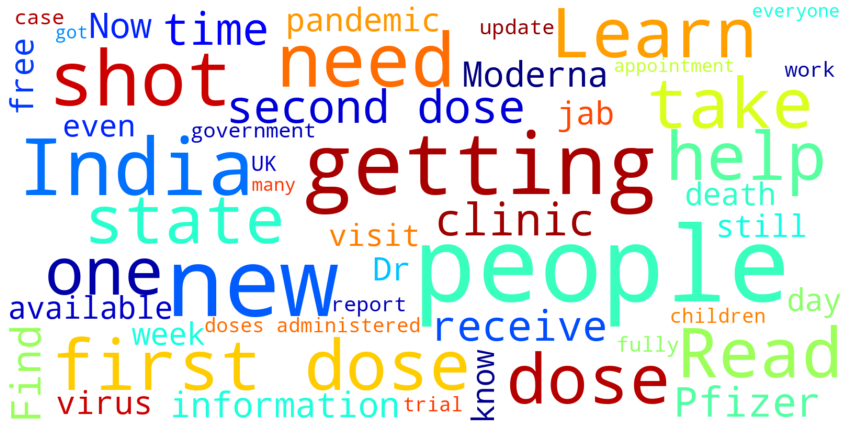

In [172]:
word_cloud(tweets_df["text_cleaned"])

In [173]:
wrd_list = tweets_df[tweets_df['nltk_sentiment']=='Positive']['text_cleaned'].values

In [174]:
word_count(wrd_list)

Word: people, count: 234
Word: dose, count: 193
Word: effective, count: 181
Word: first, count: 162
Word: doses, count: 154
Word: getting, count: 149
Word: new, count: 127
Word: help, count: 124
Word: one, count: 122
Word: protect, count: 110
Word: received, count: 109
Word: Moderna, count: 103
Word: need, count: 102
Word: million, count: 96
Word: safe, count: 96
Word: approved, count: 95
Word: free, count: 85
Word: cases, count: 84
Word: Pfizer, count: 83
Word: India, count: 82
Word: second, count: 80
Word: aged, count: 79
Word: use, count: 79
Word: information, count: 78
Word: take, count: 78
Word: eligible, count: 74
Word: know, count: 73
Word: make, count: 72
Word: health, count: 72
Word: Dr., count: 70


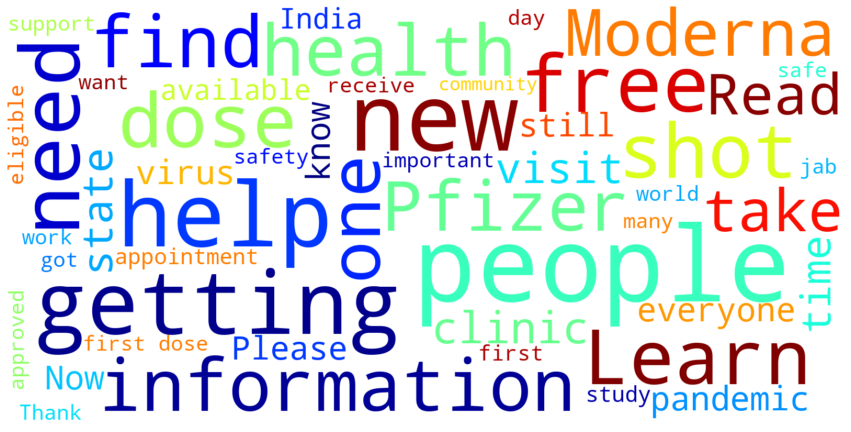

In [175]:
word_cloud(wrd_list)

In [176]:
wrd_list = tweets_df[tweets_df['nltk_sentiment']=='Negative']['text_cleaned'].values

In [177]:
word_count(wrd_list)

Word: people, count: 129
Word: one, count: 68
Word: dose, count: 59
Word: getting, count: 58
Word: cases, count: 54
Word: first, count: 53
Word: death, count: 52
Word: doses, count: 51
Word: risk, count: 50
Word: India, count: 49
Word: new, count: 46
Word: died, count: 43
Word: received, count: 42
Word: health, count: 41
Word: still, count: 39
Word: need, count: 38
Word: blood, count: 37
Word: US, count: 37
Word: may, count: 36
Word: severe, count: 32
Word: What, count: 32
Word: even, count: 30
Word: deaths, count: 30
Word: take, count: 30
Word: reports, count: 29
Word: second, count: 29
Word: hesitancy, count: 29
Word: emergency, count: 29
Word: Learn, count: 28
Word: shortage, count: 28


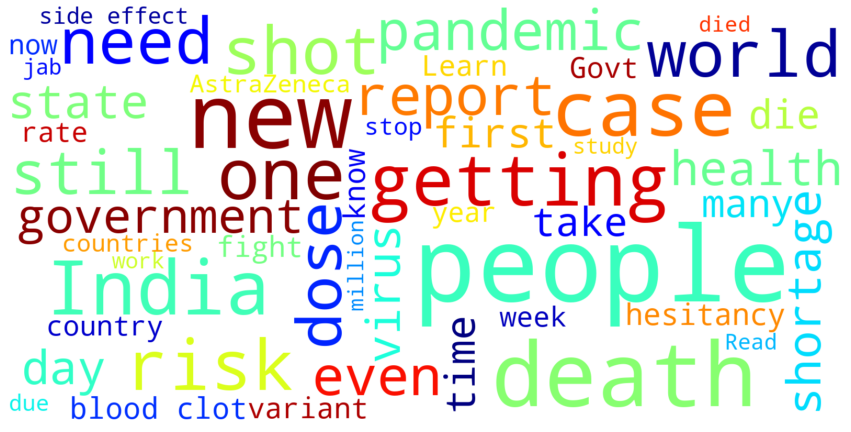

In [178]:
word_cloud(wrd_list)

In [179]:
wrd_list = tweets_df[tweets_df['nltk_sentiment']=='Neutral']['text_cleaned'].values
word_count(wrd_list)

Word: doses, count: 284
Word: dose, count: 163
Word: first, count: 161
Word: people, count: 119
Word: received, count: 96
Word: million, count: 95
Word: second, count: 94
Word: administered, count: 83
Word: available, count: 77
Word: Health, count: 74
Word: new, count: 68
Word: New, count: 64
Word: appointment, count: 60
Word: need, count: 59
Word: India, count: 59
Word: Pfizer, count: 59
Word: one, count: 55
Word: cases, count: 55
Word: receive, count: 55
Word: next, count: 53
Word: More, count: 53
Word: age, count: 51
Word: book, count: 49
Word: getting, count: 48
Word: information, count: 47
Word: eligible, count: 47
Word: aged, count: 47
Word: What, count: 45
Word: still, count: 44
Word: Get, count: 43


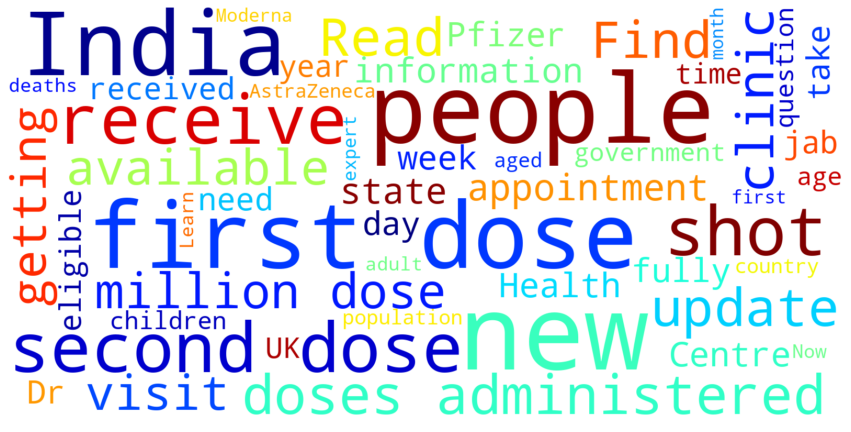

In [180]:
word_cloud(wrd_list)

In [196]:
import pandas as pd
import itertools
t0word_stems = ["dose","effective","first","doses","getting","new","help","one","protect","received","Moderna","need","million","safe","approved","free","cases","Pfizer","second"]
t1word_stems = ["people","dose","getting","cases","first","dose","shot","death","doses","risk","India","new","died","health","blood","clot","severe","hesitancy","emergency","shortage"]
#t2word_stems = ["will","Read","May","vaccine","second","dose","Dr","Health","Centre","receive","adult","first","shot","update","jab","Read"]
t0nodes = pd.DataFrame(t0word_stems, columns=['label'])
t1nodes = pd.DataFrame(t1word_stems, columns=['label'])
#t2nodes = pd.DataFrame(t2word_stems, columns=['label'])
t0nodes.to_csv("topic 0 nodes.csv", index= False)
t1nodes.to_csv("topic 1 nodes.csv", index= False)
#t2nodes.to_csv("topic 2 nodes.csv", index= False)

In [197]:
df1 = tweets_df.copy()
df1 = df1.dropna()
df1 = df1[["nltk_sentiment", "text_cleaned"]]
t0df1 = df1[(df1["nltk_sentiment"] == 'Positive')]
t1df1 = df1[(df1["nltk_sentiment"] == 'Negative')]
t0mask = t0df1['text_cleaned'].str.contains('dose|effective|first|doses|getting|new|help|one|protect|received|Moderna|need|million|safe|approved|free|cases|Pfizer|second')    
t1mask = t1df1['text_cleaned'].str.contains('ople|dose|getting|cases|first|dose|shot|death|doses|risk|India|new|died|health|blood|clot|severe|hesitancy|emergency|shortage')    

t0df1 = t0df1[t0mask]
t1df1 = t1df1[t1mask]
#t2df1 = t2df1[t2mask]
t0df1

,nltk_sentiment,text_cleaned
5,Positive,"Israel COVID update Nearly restrictions, inclu..."
7,Positive,expands immunization drive younger age group o...
9,Positive,Worth read. MJA - Communicating patients publi...
12,Positive,Should get ? The evidence says yes natural inf...
19,Positive,The Pfizer available Camden residents ages + ....
...,...,...
5900,Positive,"BBC presenter Lisa Shaw, , dies Covid jab safe?"
5904,Positive,The government offer incentives - rebates quit...
5907,Positive,"As got approval good hear!! ""European Medicine..."
5909,Positive,claim completely safeHealth Tips Dr Showkat Sh...


In [198]:
t0df1['tidy_tweet_list'] = t0df1['text_cleaned'].apply(lambda x: x.split())
t1df1['tidy_tweet_list'] = t1df1['text_cleaned'].apply(lambda x: x.split())

#Edges for each dominant topic
t0df1

,nltk_sentiment,text_cleaned,tidy_tweet_list
5,Positive,"Israel COVID update Nearly restrictions, inclu...","[Israel, COVID, update, Nearly, restrictions,,..."
7,Positive,expands immunization drive younger age group o...,"[expands, immunization, drive, younger, age, g..."
9,Positive,Worth read. MJA - Communicating patients publi...,"[Worth, read., MJA, -, Communicating, patients..."
12,Positive,Should get ? The evidence says yes natural inf...,"[Should, get, ?, The, evidence, says, yes, nat..."
19,Positive,The Pfizer available Camden residents ages + ....,"[The, Pfizer, available, Camden, residents, ag..."
...,...,...,...
5900,Positive,"BBC presenter Lisa Shaw, , dies Covid jab safe?","[BBC, presenter, Lisa, Shaw,, ,, dies, Covid, ..."
5904,Positive,The government offer incentives - rebates quit...,"[The, government, offer, incentives, -, rebate..."
5907,Positive,"As got approval good hear!! ""European Medicine...","[As, got, approval, good, hear!!, ""European, M..."
5909,Positive,claim completely safeHealth Tips Dr Showkat Sh...,"[claim, completely, safeHealth, Tips, Dr, Show..."


In [199]:
#only keep words in word stems list
t0df1["reduced"] = t0df1['tidy_tweet_list'].apply(lambda x: [item for item in x if item in t0word_stems])
t1df1["reduced"] = t1df1['tidy_tweet_list'].apply(lambda x: [item for item in x if item in t1word_stems])
t1df1

,nltk_sentiment,text_cleaned,tidy_tweet_list,reduced
16,Negative,"Immoral, Tied To Use Fetal Tissue, Therefore A...","[Immoral,, Tied, To, Use, Fetal, Tissue,, Ther...",[]
22,Negative,Our Prof warns Australia heed Taiwan's experie...,"[Our, Prof, warns, Australia, heed, Taiwan's, ...",[cases]
40,Negative,"The difference months makes, tragic given shor...","[The, difference, months, makes,, tragic, give...","[shortage, people]"
50,Negative,"On 2221, cases reported (0.7) hospitalized (to...","[On, 2221,, cases, reported, (0.7), hospitaliz...","[cases, dose]"
60,Negative,"In swine flu million vaxxed,the halted risky d...","[In, swine, flu, million, vaxxed,the, halted, ...",[]
...,...,...,...,...
5882,Negative,The Public Health Ministry started providing C...,"[The, Public, Health, Ministry, started, provi...",[people]
5895,Negative,Who responsible crisis shortage ??,"[Who, responsible, crisis, shortage, ??]",[shortage]
5897,Negative,"After weeks waiting, 's mum received first dos...","[After, weeks, waiting,, 's, mum, received, fi...","[first, dose]"
5902,Negative,Hotel package common people struggling get slo...,"[Hotel, package, common, people, struggling, g...",[people]


In [203]:
t0df1['reduced'] = [' '.join(map(str, l)) for l in t0df1['reduced']]
count = t0df1['reduced'].str.split().str.len()
#only keep lists with more than 1 words in the list (only keep words with a connection)
t0df1 = t0df1[~(count<=1)]
t0df1["reduced"] = t0df1["reduced"].apply(lambda x: x.split())
t1df1['reduced'] = [' '.join(map(str, l)) for l in t1df1['reduced']]
count = t1df1['reduced'].str.split().str.len()
#only keep lists with more than 1 words in the list (only keep words with a connection)
t1df1 = t1df1[~(count<=1)]
t1df1["reduced"] = t1df1["reduced"].apply(lambda x: x.split())

C:\Users\mshan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mshan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [204]:
#combination (nC2)
def combine(row):
  comb_list = []
  for comb in itertools.combinations(row, 2):
    comb_list.append(comb)
  return comb_list
t0df1["comb"] = t0df1["reduced"].apply (lambda row: combine(row))
t1df1["comb"] = t1df1["reduced"].apply (lambda row: combine(row))

t0df1

,nltk_sentiment,text_cleaned,tidy_tweet_list,reduced,comb
5,Positive,"Israel COVID update Nearly restrictions, inclu...","[Israel, COVID, update, Nearly, restrictions,,...","[cases, cases]","[(cases, cases)]"
21,Positive,Nice see Canada passed US share people receive...,"[Nice, see, Canada, passed, US, share, people,...","[received, one, second]","[(received, one), (received, second), (one, se..."
31,Positive,"administered million doses vaccine, million pa...","[administered, million, doses, vaccine,, milli...","[million, doses, million]","[(million, doses), (million, million), (doses,..."
92,Positive,Delaying COVID vaccines second dose boosts imm...,"[Delaying, COVID, vaccines, second, dose, boos...","[second, dose]","[(second, dose)]"
135,Positive,Double dose effective Indian B.1.617.2 variant...,"[Double, dose, effective, Indian, B.1.617.2, v...","[dose, effective]","[(dose, effective)]"
...,...,...,...,...,...
5777,Positive,US redirects order manufacturing supplies help...,"[US, redirects, order, manufacturing, supplies...","[help, million]","[(help, million)]"
5780,Positive,Covid showing mercy Even youngsters losing liv...,"[Covid, showing, mercy, Even, youngsters, losi...","[getting, doses]","[(getting, doses)]"
5788,Positive,Pfizer-BioNTech's become first globally approv...,"[Pfizer-BioNTech's, become, first, globally, a...","[first, approved]","[(first, approved)]"
5792,Positive,"As roll-out progressing, wanted remind blog Si...","[As, roll-out, progressing,, wanted, remind, b...","[first, dose]","[(first, dose)]"


In [205]:
from  itertools import chain
edges_df_topic0 = pd.DataFrame(list(chain.from_iterable(t0df1.comb)), columns=['from','to']).reset_index(drop=True)
edges_df_topic0.head()

,from,to
0,cases,cases
1,received,one
2,received,second
3,one,second
4,million,doses


In [206]:
from  itertools import chain
edges_df_topic1 = pd.DataFrame(list(chain.from_iterable(t1df1.comb)), columns=['from','to']).reset_index(drop=True)
edges_df_topic1


,from,to
0,shortage,people
1,cases,dose
2,doses,first
3,doses,dose
4,doses,dose
...,...,...
288,blood,severe
289,blood,death
290,severe,death
291,first,dose


In [207]:
from  itertools import chain
edges_df_topic0 = pd.DataFrame(list(chain.from_iterable(t0df1.comb)), columns=['from','to']).reset_index(drop=True)
edges_df_topic0.head()
from  itertools import chain
edges_df_topic1 = pd.DataFrame(list(chain.from_iterable(t1df1.comb)), columns=['from','to']).reset_index(drop=True)
edges_df_topic1.head()


edges_df_topic0.to_csv("edges word stem topic0 1.csv", index= False)
edges_df_topic1.to_csv("edges word stem topic1 1.csv", index= False)